In [1]:
!pip install tensorflow gradio matplotlib seaborn pillow scikit-learn


In [7]:
import os

# Check what's inside the inner "modified-dataset"
inner_path = '/content/modified-dataset/modified-dataset'
print("Folders inside modified-dataset:", os.listdir(inner_path))

# Optional: check classes inside the training folder
train_path = os.path.join(inner_path, 'train')
print("Classes inside train/:", os.listdir(train_path))


Folders inside modified-dataset: ['train', 'test', 'val']
Classes inside train/: ['Mouse', 'Mobile', 'Television', 'Printer', 'Microwave', 'Battery', 'Player', 'Washing Machine', 'Keyboard', 'PCB']


In [11]:
import tensorflow as tf  # ✅ Add this at the top
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_PATH = '/content/modified-dataset/modified-dataset'

# Preprocessing & augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Preprocessing for validation and testing (no augmentation)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Load datasets
train_data = train_datagen.flow_from_directory(
    directory=os.path.join(DATA_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = test_datagen.flow_from_directory(
    directory=os.path.join(DATA_PATH, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    directory=os.path.join(DATA_PATH, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [12]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model

# Number of classes in your dataset
num_classes = train_data.num_classes

# Load base model (without top classification layer)
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

# Optional: freeze base model layers for faster training
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,084,570 (23.21 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [13]:
# Optional: Add early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


75/75 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.6219 - loss: 1.2178 - val_accuracy: 0.9633 - val_loss: 0.1614
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9288 - loss: 0.2401 - val_accuracy: 0.9633 - val_loss: 0.1290
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9425 - loss: 0.1987 - val_accuracy: 0.9700 - val_loss: 0.1268
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.9463 - loss: 0.1622 - val_accuracy: 0.9733 - val_loss: 0.1127
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9525 - loss: 0.1382 - val_accuracy: 0.9700 - val_loss: 0.1156
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.9603 - loss: 0.1261 - val_accuracy: 0.9667 - val_loss: 0.1314
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.9593 - loss: 0.1182 - val_accuracy: 0.9633 - val_loss: 0.1368


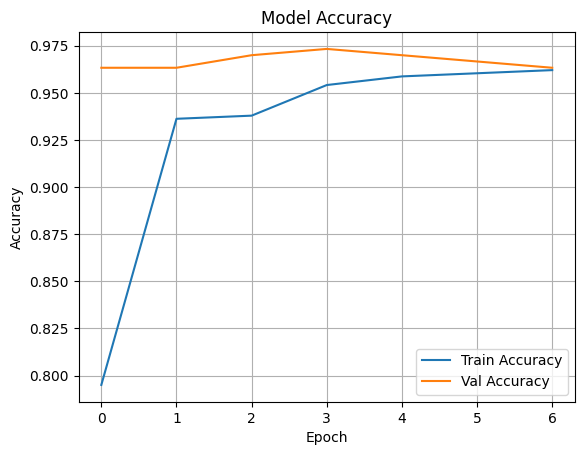

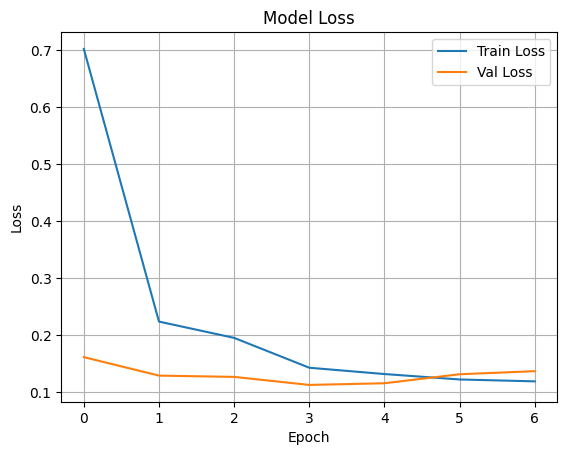

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9703 - loss: 0.1282
Test Accuracy: 0.9700
Test Loss: 0.1235


In [18]:
model.save('e_waste_classifier.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


 9/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step
Classification Report:

                 precision    recall  f1-score   support

        Battery       0.94      0.97      0.95        30
       Keyboard       1.00      0.97      0.98        30
      Microwave       0.91      0.97      0.94        30
         Mobile       1.00      1.00      1.00        30
          Mouse       0.94      1.00      0.97        30
            PCB       1.00      0.93      0.97        30
         Player       1.00      0.93      0.97        30
        Printer       1.00      1.00      1.00        30
     Television       0.97      0.93      0.95        30
Washing Machine       0.97      1.00      0.98        30

       accuracy                           0.97       300
      macro avg       0.97      0.97      0.97       300
   weighted avg       0.97      0.97      0.97       300



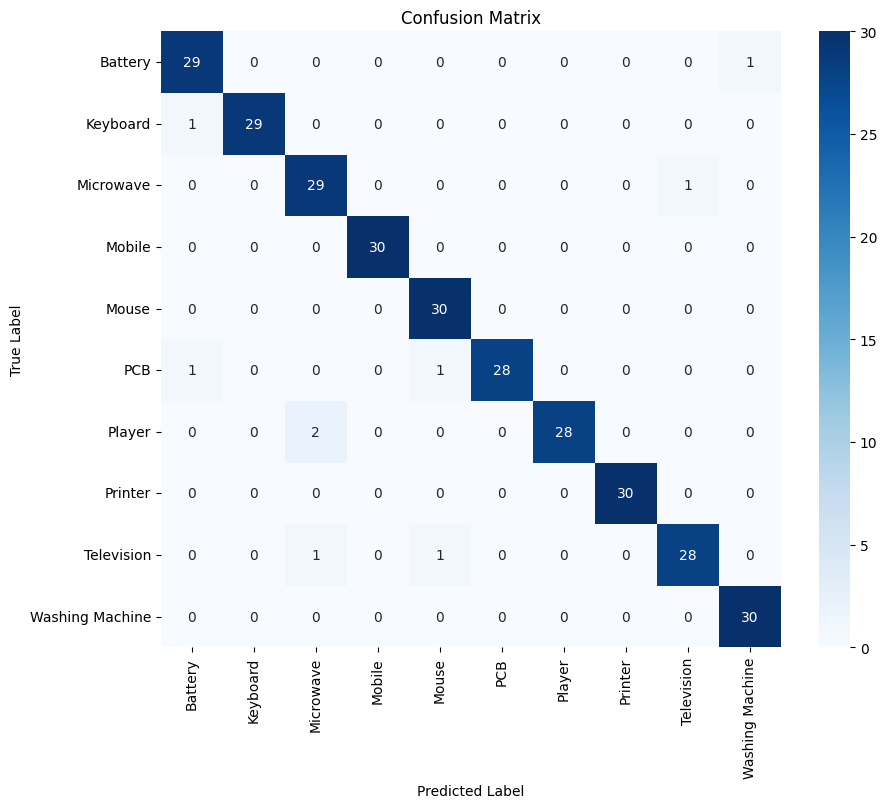

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices
y_true = test_data.classes  # true class indices
class_labels = list(test_data.class_indices.keys())  # class names

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



In [20]:
import gradio as gr
from PIL import Image
import numpy as np


In [21]:
# Use same class labels as your dataset
class_labels = list(test_data.class_indices.keys())

def classify_image(img: Image.Image):
    # Resize to model input size
    img = img.resize((224, 224))

    # Convert to array and preprocess
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)[0]

    # Map predictions to class labels
    return {class_labels[i]: float(predictions[i]) for i in range(len(class_labels))}


In [22]:
gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="E-Waste Image Classifier",
    description="Upload an image of an electronic item to classify it into 1 of 10 e-waste categories."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2d2a2005b3f882a28f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [23]:
model.save('e_waste_classifier.keras')


In [24]:
from google.colab import files
files.download('e_waste_classifier.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>